In [7]:
#https://www.geeksforgeeks.org/using-jupyter-notebook-in-virtual-environment/
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.cluster import KMeans
from yellowbrick.cluster import InterclusterDistance, KElbowVisualizer, SilhouetteVisualizer

# Plan for first iteration
- Fit Gaussian mixture models on float variables
    - Maybe try a model only with f_21 to f_28
- Fit a k-means to the integer variables
- Combine both model result using a standard ensemble algorithm
    - Try using a similarity matrix: https://towardsdatascience.com/how-to-ensemble-clustering-algorithms-bf78d7602265
- Repeat Using PCA
    - It shouldn't be necessary to scale the variables I think, but keep in mind that I can be wrong.

In [35]:
dtypes = {
        'f_00':'float32',
        'f_01': 'float32',
        'f_02':'float32',
        'f_03': 'float32',
        'f_04':'float32',
        'f_05': 'float32',
        'f_06':'float32',
        'f_07': 'int8',
        'f_08':'int8',
        'f_09': 'int8',
        'f_10':'int8',
        'f_11': 'int8',
        'f_12':'int8',
        'f_13': 'int8',
        'f_14':'float32',
        'f_15': 'float32',
        'f_16':'float32',
        'f_17': 'float32',
        'f_18':'float32',
        'f_19': 'float32',
        'f_20':'float32',
        'f_21': 'float32',
        'f_22':'float32',
        'f_23': 'float32',
        'f_24':'float32',
        'f_25': 'float32',
        'f_26':'float32',
        'f_27': 'float32',
        'f_28':'float32',
        'f_29': 'float32',
         }
df = pd.read_csv('../data/raw/data.csv')
df.dtypes
df = df.drop(['id'],axis=1)

id        int64
f_00    float64
f_01    float64
f_02    float64
f_03    float64
f_04    float64
f_05    float64
f_06    float64
f_07      int64
f_08      int64
f_09      int64
f_10      int64
f_11      int64
f_12      int64
f_13      int64
f_14    float64
f_15    float64
f_16    float64
f_17    float64
f_18    float64
f_19    float64
f_20    float64
f_21    float64
f_22    float64
f_23    float64
f_24    float64
f_25    float64
f_26    float64
f_27    float64
f_28    float64
dtype: object

In [9]:
int_cols = []
float_cols = []
for c,t in zip([col for col in df.columns], [col for col in df.dtypes]):
    if 'int' in str(t):
        if str(c) != 'id':
            int_cols.append(c)
    elif 'float' in str(t):
        float_cols.append(c)
    else:
        print(f'something went wrong for {c}')

In [10]:
# We expect f22 to f28, as well as all the integer cols to be the most important, therefore we set a boolean variable
# for ease of use to indicate whether we want to use only these variables or not.
use_important_cols_only = True
important_float_cols = ['f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28']
if use_important_cols_only:
    df = df[int_cols + important_float_cols]
else:
    df = df[float_cols + int_cols]

In [11]:
def enrich_df_with_random_interactions(df):
    cols = df.columns.tolist()
    sample_list_1 = random.choices(cols,k= 50)
    sample_list_2 = random.choices(cols,k= 50)
    for col_1, col_2 in zip(sample_list_1, sample_list_2):
        if col_1 == col_2:
            continue
        x = df[col_1] * df[col_2]

        df[f'{col_1}*{col_2}'] = x
    return df
enrich_data=False
if enrich_data:
    enrich_df_with_random_interactions(df)

In [12]:
scale_data = True
if scale_data:
    scaler = PowerTransformer()
    scaler.fit(df)
    df_final = scaler.transform(df_final)

In [16]:
def plot_pca_variance(df):
    pca = PCA()
    pca.fit(df)
    exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

    return px.area(
        x=range(1, exp_var_cumul.shape[0] + 1),
        y=exp_var_cumul,
        labels={"x": "# Components", "y": "Explained Variance"}
    )
apply_pca=False
if apply_pca:
    plot_pca_variance(df_final)

In [17]:
def get_pca_components(df, components):
    pca = PCA(n_components=components)
    components = pca.fit_transform(df)
    return components
if apply_pca:
    components = 6
    cols_selected = float_cols+int_cols
    tst = get_pca_components(df_final[cols_selected], components)
    col_list = [f'c_{i}' for i in range(0,components)]
    df_final = pd.DataFrame(tst, columns=col_list)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


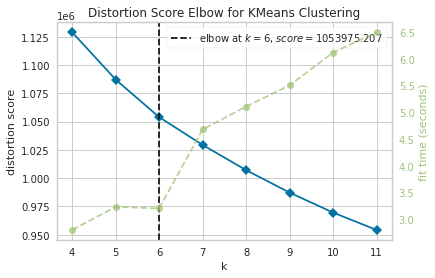

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import InterclusterDistance, KElbowVisualizer, SilhouetteVisualizer
# Instantiate the clustering model and visualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(df)    # Fit the data to the visualizer
visualizer.show()    # Finalize and render the figure

In [19]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

def fit_gmm(X, covariance_type):
    gm = GaussianMixture(n_components=6,covariance_type=covariance_type, random_state=0).fit(X)
    pred = gm.predict(X)
    bic = gm.bic(X)
    return bic

def grid_search_gmm(df, verbose=True):
    covariance_type_list = ['full', 'tied', 'diag', 'spherical']
    result_list = {}
    top_score = 1000000000
    params = {}
    best_params = params
    for covariance_type in covariance_type_list:
        X = df
        score = fit_gmm(X, covariance_type)
        result_list[covariance_type] = score
        params = {'covariance_type': covariance_type}
        if verbose:
            print(f'{params} scored {score}')
        if score <= top_score:
            top_score = score
            best_params = params
            if verbose:
                print(f'covariance_type {covariance_type} has best score with {top_score} ')
    print(f'Winner is model with params {best_params} and bic: {top_score}')
    return result_list
result_list_float = grid_search_gmm(df_final)

{'covariance_type': 'full'} scored 3679619.743606119
covariance_type full has best score with 3679619.743606119 
{'covariance_type': 'tied'} scored 3763828.083061296
{'covariance_type': 'diag'} scored 3763775.5644152365
{'covariance_type': 'spherical'} scored 3815106.627295143
Winner is model with params {'covariance_type': 'full'} and bic: 3679619.743606119


In [20]:
gmm = GaussianMixture(n_components=6,covariance_type='full', random_state=0)
gmm.fit(df_final)

GaussianMixture(n_components=6, random_state=0)

In [21]:
pred = gmm.predict(df_final)
# submission_df = pd.DataFrame({'Id': df['id'].tolist(), 'Predicted': pred}).set_index('Id')
# submission_df.to_csv('src/models/' + file_name)

In [24]:
df.reset_index()['index'].tolist()

AttributeError: 'numpy.ndarray' object has no attribute 'reset_index'

In [37]:
submissions_df = pd.DataFrame({'Id': [i for i in range(0, len(df_final))], 'Predicted': pred}).set_index('Id')

In [38]:
submissions_df.to_csv('submission_i2.csv')